### Optimizing the CA criteria using keras

In [1]:
import numpy as np
import uproot
import math

In [3]:
f = uproot.open( "mltree.root" )
mltree = f["Stg"]

<TTree b'Stg' at 0x000117ea84a8>

In [5]:
import matplotlib.pyplot as plt
fs = ( 16, 9 ) # lets make all our figures 16 by 9

In [6]:
xyztv = mltree.arrays( [ "x", "y", "z", "tid", "vid" ]  )
mct = mltree.arrays( ["pt", "eta", "phi"] )

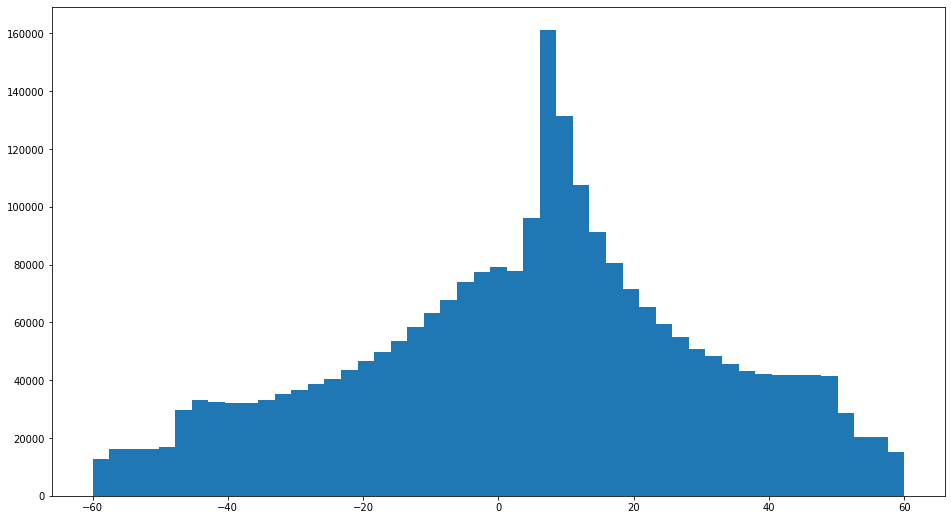

In [9]:
plt.figure(figsize=fs)
plt.hist( xyztv[b"y"].flatten(), bins=np.linspace(-60, 60, 50) )
plt.show()

In [20]:
class HitPoint:
    def __init__( self, _x, _y, _z, _v, _t ):
        self.x = _x
        self.y = _y
        self.z = _z
        self.v = _v
        self.t = _t
    def __repr__( self ):
        return 'HitPoint[v=%d, (%0.3f, %0.3f, %0.3f), tid=%d]' % ( self.v, self.x, self.y, self.z, self.t )
class TwoHit:
    def __init__( self, _a, _b):
        self.a = _a
        self.b = _b

    
class CriteriaResult:
    def __init__(self):
        self.real = False
        self.res = -99
        self.pt = -99
        self.eta = -99
        self.phi = -99
    
        
def generate_vol_map( x, y, z, v, t, phi0, phi1 ):
    vol_map = [ [], [], [], [] ] # maps to 4 volumes
    for _x, _y, _z, _v, _t in zip(  x, y, z, v, t ):
        phi = math.atan2( _y, _x )
        if phi < phi1 and phi >= phi0 :
            vol_map[_v].append( HitPoint( _x, _y, _z, _v, _t ) )
    return vol_map
    #vol_map[]
    #print( len(x) )

def gen_pairs( vm ) :
    hp = []
    for i in np.arange( 0, 3 ):
        for a in vm[i] :
            for b in vm[i+1]:
                hp.append( (a,b) )
    return hp

def process_pairs( hp, pts, crit ):
    crs = []
    
    for points in hp:
        a = points[0]
        b = points[1]
        cr = CriteriaResult()
        cr.res = crit(a, b)
        cr.real = (a.t == b.t)
        if cr.real :
            cr.pt = pts[a.t - 1]
        crs.append( cr )
        
    return crs


def crit_rz( a, b ):
    dx = a.x-b.x
    dy = a.y-b.y
    dz = a.z-b.z
    return (dx**2+dy**2+dz**2)/dz**2;

M_PI = 3.1415926
def crit_dphi( a, b ):
    phia = math.atan2( a.y, a.x )
    phib = math.atan2(b.y, b.x)
    deltaPhi = phia-phib
    if deltaPhi > M_PI :
        deltaPhi = deltaPhi - 2*M_PI
    if deltaPhi < -M_PI:
        deltaPhi = deltaPhi + 2*M_PI
    if ( b.y*b.y + b.x*b.x < 0.0001 ) or ( a.y*a.y + a.x*a.x < 0.0001 ):
        deltaPhi = 0
    deltaPhi = 180. * math.fabs( deltaPhi ) / M_PI
    return deltaPhi

def crit_deltaRho( a, b ):
    rhoA =  math.sqrt( a.x*a.x + a.y*a.y );
    rhoB =  math.sqrt( b.x*b.x + b.y*b.y );

    deltaRho = rhoA - rhoB;
    return deltaRho

def pair_stats( pairs ):
    nr = 0
    nf = 0
    for p in pairs:
        if p[0].t == p[1].t:
            nr = nr + 1
        else :
            nf = nf + 1
#     print( "There are %d real and %d fake pairs, with %f %% real" % ( nr, nf, (nr / len(pairs)) ) ) 
    return (nr, nf, (nr / len(pairs)) )

In [23]:
iEvent = 0
vm = generate_vol_map( xyztv[b"x"][iEvent], xyztv[b"y"][iEvent], xyztv[b"z"][iEvent], xyztv[b"vid"][iEvent], xyztv[b"tid"][iEvent], 0, math.pi / 2.0 )
pairs = gen_pairs(vm)

pairs

[(HitPoint[v=0, (7.543, 20.994, 280.905), tid=302],
  HitPoint[v=1, (8.503, 24.978, 303.705), tid=302]),
 (HitPoint[v=0, (7.543, 20.994, 280.905), tid=302],
  HitPoint[v=1, (16.451, 21.481, 303.705), tid=328]),
 (HitPoint[v=0, (14.246, 18.194, 280.905), tid=328],
  HitPoint[v=1, (8.503, 24.978, 303.705), tid=302]),
 (HitPoint[v=0, (14.246, 18.194, 280.905), tid=328],
  HitPoint[v=1, (16.451, 21.481, 303.705), tid=328]),
 (HitPoint[v=1, (8.503, 24.978, 303.705), tid=302],
  HitPoint[v=2, (9.475, 29.001, 326.605), tid=302]),
 (HitPoint[v=1, (8.503, 24.978, 303.705), tid=302],
  HitPoint[v=2, (18.730, 24.746, 326.605), tid=328]),
 (HitPoint[v=1, (16.451, 21.481, 303.705), tid=328],
  HitPoint[v=2, (9.475, 29.001, 326.605), tid=302]),
 (HitPoint[v=1, (16.451, 21.481, 303.705), tid=328],
  HitPoint[v=2, (18.730, 24.746, 326.605), tid=328]),
 (HitPoint[v=2, (9.475, 29.001, 326.605), tid=302],
  HitPoint[v=3, (10.435, 32.974, 349.405), tid=302]),
 (HitPoint[v=2, (9.475, 29.001, 326.605), tid=

In [31]:
all_pairs = []
all_mapped_pts = []
all_RZ = []
all_DP = []
all_DR = []

for iEvent in np.arange( len(xyztv[b"x"]) ) :
    vm = generate_vol_map( xyztv[b"x"][iEvent], xyztv[b"y"][iEvent], xyztv[b"z"][iEvent], xyztv[b"vid"][iEvent], xyztv[b"tid"][iEvent], 0, math.pi/4 )
    pts = mct[ b"pt" ][iEvent]
    pairs = gen_pairs( vm )
    all_pairs.extend( pairs )
    
    mapped_pts = [ pts[ p[0].t ] if p[0].t == p[1].t else 0.0 for p in pairs  ]
    all_mapped_pts.extend( mapped_pts )
    
    if iEvent % 5000 == 0:
        print( "Event %d" %(iEvent))
#     inr, inf, ipur = pair_stats( pairs )

    

Event 0
Event 5000
Event 10000
Event 15000
Event 20000
Event 25000
Event 30000
Event 35000
Event 40000
Event 45000


In [36]:
len(all_pairs)

857586

In [35]:
all_RZ = [ crit_rz( p[0], p[1] ) for p in all_pairs ]

In [ ]:
RZ_real = [ rz for i, rz in enumerate(all_RZ) if all_pairs[i][0].t == all_pairs[i][1].t  ]
RZ_fake = [ rz for i, rz in enumerate(all_RZ) if all_pairs[i][0].t != all_pairs[i][1].t  ]

plt.figure(figsize=fs)
plt.hist( RZ_real, bins=np.linspace(0.8, 10, 600), fc='red' )
plt.hist( RZ_fake, bins=np.linspace(0.8, 10, 600), fc='blue', alpha=0.4 )
plt.yscale('log')
plt.show()

In [ ]:

all_DP = [ crit_dphi( p[0], p[1] ) for p in all_pairs ]
all_DR = [ crit_deltaRho( p[0], p[1] ) for p in all_pairs ]

In [40]:
len( all_pairs )

368302

In [41]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [128]:
def build_model() :
    model = Sequential()
    model.add(Dense(20, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model

In [129]:
# Get the model built in the function above
model = build_model()
# compile the model and set the loss function, optimizer and metrics to check during training.
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                80        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [130]:
n_pairs = len( all_pairs )
X_train = np.empty( shape=(3, n_pairs) )
Y_train = np.empty( shape=(n_pairs, ) )

for iPair in np.arange( n_pairs ) :
        X_train[0][iPair] = all_RZ[iPair]
        X_train[1][iPair] = all_DP[iPair]
        X_train[2][iPair] = all_DR[iPair]
        
        if all_pairs[iPair][0].t == all_pairs[iPair][1].t and all_pairs[iPair][1].t <= 10:
            Y_train[iPair] = 1
        else :
            Y_train[iPair] = 0
X_train = np.transpose(X_train)

In [131]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=100,  verbose=1, validation_split=0.33)

Train on 246762 samples, validate on 121540 samples
Epoch 1/20
246762/246762 [==============================] - 4s 16us/sample - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.0667 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0554
Epoch 2/20
246762/246762 [==============================] - 3s 13us/sample - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0516 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0422
Epoch 3/20
246762/246762 [==============================] - 3s 14us/sample - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0479 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0394
Epoch 4/20
246762/246762 [==============================] - 3s 14us/sample - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0455 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0366
Epoch 5/

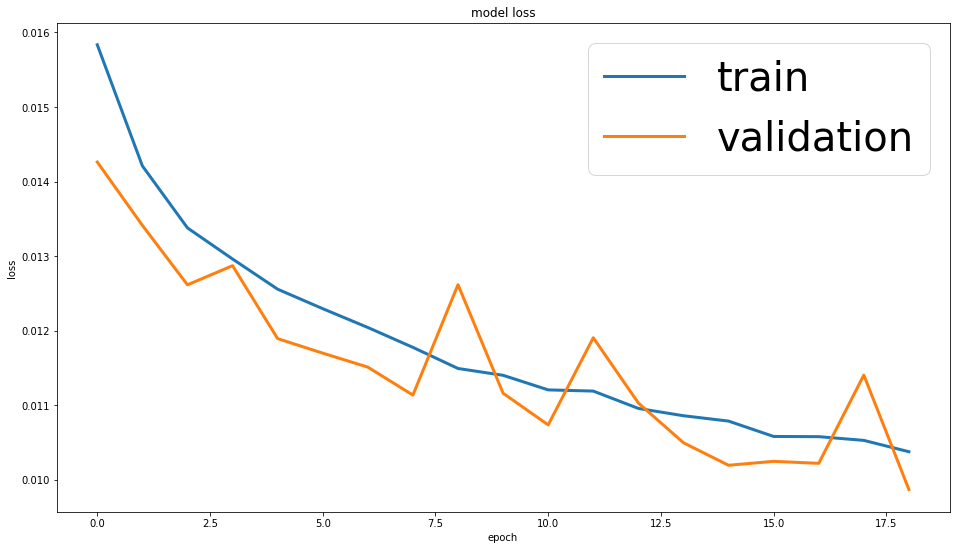

In [132]:
plt.figure(figsize=fs)
# print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'][1:], linewidth=3)
plt.plot(history.history['val_loss'][1:], linewidth=3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right', prop={'size': 40})
# plt.gca().set_ylim((0, 1))
# plt.semilogy()
plt.show()

In [133]:
Y_pred = np.array(model.predict(X_train))

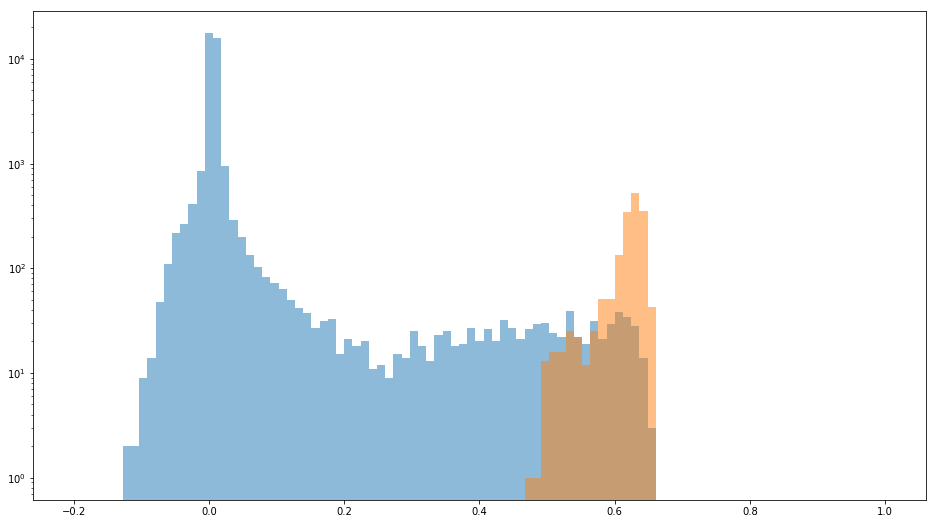

In [135]:
plt.figure(figsize=fs)
plt.hist( [ y0[0] for y0, y1 in zip(Y_pred[:40000], Y_train[:40000]) if y1 == 0 ], bins=np.linspace( -0.2, 1.0, 100 ), alpha=0.5 )
plt.hist( [ y0[0] for y0, y1 in zip(Y_pred[:40000], Y_train[:40000]) if y1 == 1 ], bins=np.linspace( -0.2, 1.0, 100 ), alpha=0.5 )
plt.semilogy()
plt.show()

In [152]:
pifg = [ y0[0] for y0, y1 in zip(Y_pred[:10000], Y_train[:10000]) if y1 == 1 and y0[0] > 0.5 ]
pifb = [ y0[0] for y0, y1 in zip(Y_pred[:10000], Y_train[:10000]) if y1 == 0 and y0[0] > 0.5 ]

print( "purity = %f" %( len( pifg ) / ( len(pifg) + len(pifb) ) )  )

purity = 0.851240


In [153]:
pifg = [ y0[0] for y0, y1 in zip(Y_pred[:10000], Y_train[:10000]) if y1 == 1 and y0[0] > 0.5 ]
pifgall = [ y0[0] for y0, y1 in zip(Y_pred[:10000], Y_train[:10000]) if y1 == 1 and y0[0] >= 0.0 ]
print ( "efficiency = %f" % ( len(pifg) / len(pifgall) ) )

efficiency = 0.995169


### TODO: Make ROC curves

In [148]:
n_steps = 100
x = np.empty( (n_steps,), dtype=float )
y = np.empty( (n_steps,), dtype=float )

pifgall = [ y0[0] for y0, y1 in zip(Y_pred[:10000], Y_train[:10000]) if y1 == 1 and y0[0] >= 0.1 ]
pifball = [ y0[0] for y0, y1 in zip(Y_pred[:10000], Y_train[:10000]) if y1 == 0 and y0[0] >= 0.1 ]

zcut = 0.0
for index, cut in enumerate(np.linspace( 0.0, 1.0, n_steps )) :
#     print( index, cut )
    
    pifg = [ y0[0] for y0, y1 in zip(Y_pred[:10000], Y_train[:10000]) if y1 == 1 and y0[0] > cut and y0[0] > zcut ]

    seff = len(pifg) / len(pifgall)

    pifb = [ y0[0] for y0, y1 in zip(Y_pred[:10000], Y_train[:10000]) if y1 == 0 and y0[0] < cut and y0[0]  > zcut ]
    
    beff = len(pifb) / len(pifball)
    
    x[ index ] = seff
    y[ index ] = beff
    

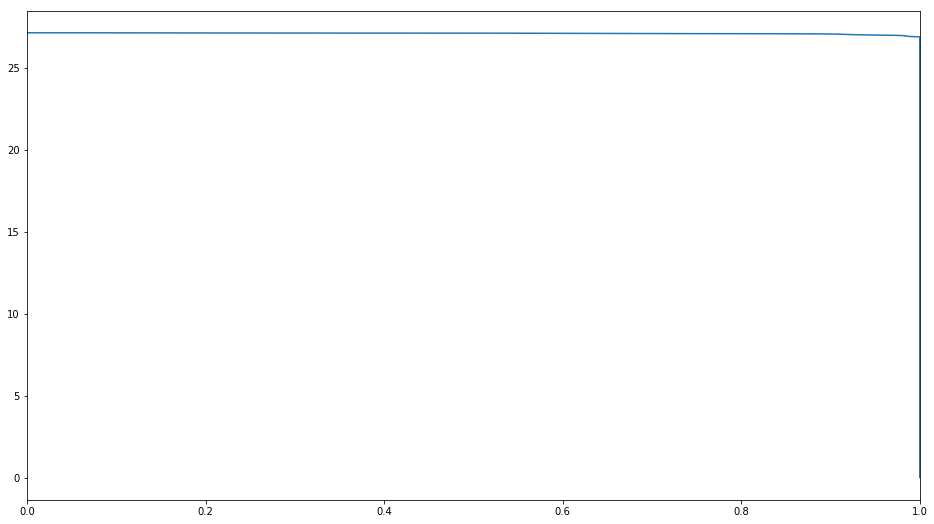

In [149]:
plt.figure(figsize=fs)
plt.plot( x, y)
plt.xlim([0.0, 1.0])
plt.show()

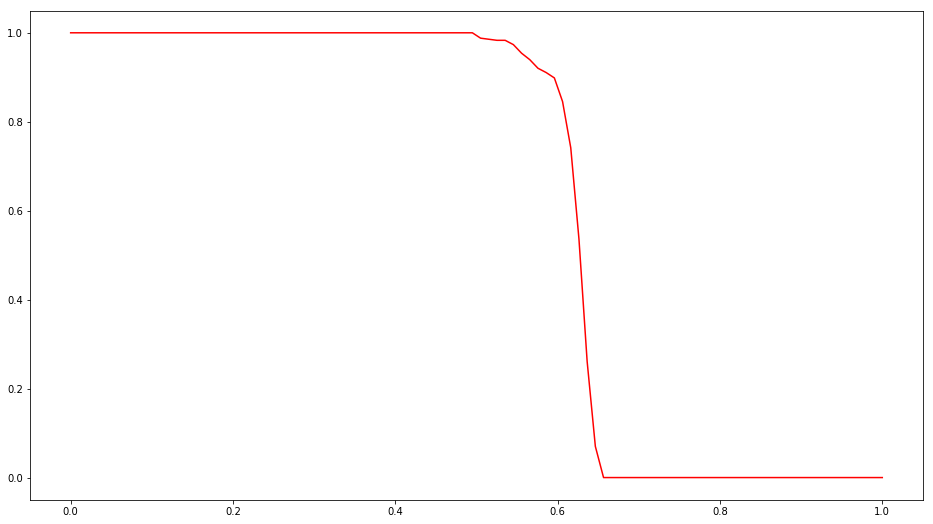

In [150]:
plt.figure( figsize=fs )
plt.plot( np.linspace( 0.0, 1.0, n_steps ), x, c='r' )
plt.show()

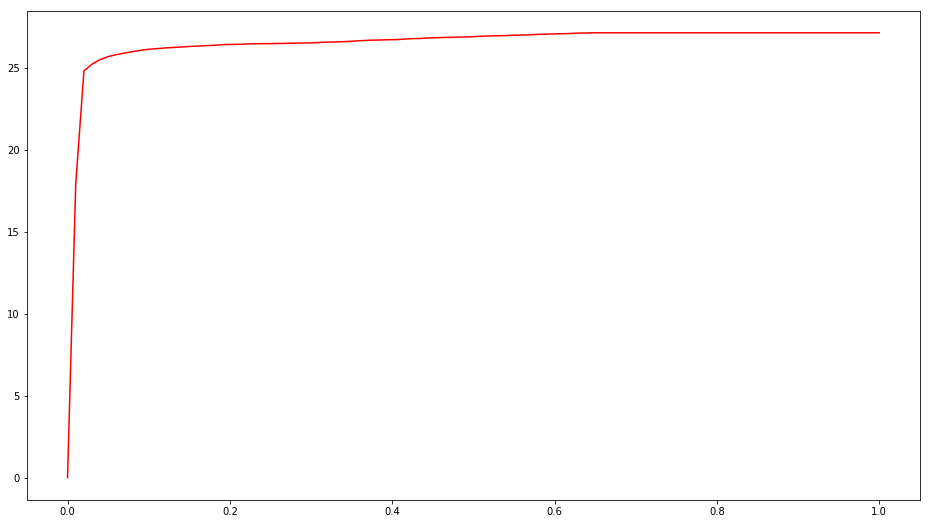

In [151]:
plt.figure( figsize=fs )
plt.plot( np.linspace( 0.0, 1.0, n_steps ), y, c='r' )
plt.show()

In [154]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [155]:
%ls

Coverage.ipynb                     draw_sTGC_quads.ipynb
NNOptimized2SegmentCriteria.ipynb  model.h5
TrackingTrees.ipynb                model.json


## Evaluate Model event-by-event

In [159]:
from tensorflow.python.keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])


Loaded model from disk


In [ ]:
def predict_pair( p ) :
    


for iEvent in np.arange( len(xyztv[b"x"]) ) :
    vm = generate_vol_map( xyztv[b"x"][iEvent], xyztv[b"y"][iEvent], xyztv[b"z"][iEvent], xyztv[b"vid"][iEvent], xyztv[b"tid"][iEvent] )
    pts = mct[ b"pt" ][iEvent]
    pairs = gen_pairs( vm )
    all_pairs.extend( pairs )
    
    mapped_pts = [ pts[ p[0].t ] if p[0].t == p[1].t else 0.0 for p in pairs  ]
    all_mapped_pts.extend( mapped_pts )
    
    inr, inf, ipur = pair_stats( pairs )
